# Introduction to Deep Learning Project - Sports Image Classification
By: Tom Kessous 206018749 & Dan Ben Ami 316333079

## Introduction

Our project deals with the problem of Image Classification. Our database contains 11,000 images from 73 different sports categories (football, basketball, bowling, golf, etc.).
###Data Description:
Our data has been divided into a training, validation and test sets. Each image in the training and validation set has its own label, which indicates the type of sport of the image. Our goal is to train a model who classifies a sports image from one of the categories (73 different categories) into its type.

The training set contain 10,416 images, the validation and test sets contain 365 images each. Each image in the dataset has shape of 3x224x224, this shape yeild high computatuonal complaxity, Therefore, we resized the images to shape 3x112x112.

###Challenges:
The biggest difficulty in this dataset is the amount of classes, if most classification problems have a small number of options for example "dog or cat" and therefore a random guess will result in 50% accuracy. Our problem has 73 different classes and therefore a random guess will only result in 1.3% Accuracy. Despite of this challenge, We have managed to achieve 85% accuracy on the test set with ResNet50 model.

###Project Structure:
The project is build from 3 main parts:



*   **part A - Data Preparation**: in this part we prepare the data for the training process and represent an example of how it looks like.
*   **part B - Models Comparison**: in this part we train 6 different model's architechtures, each one with different hyper-parameters, evetually we compare them and continue to the next part with the best one of them.
*   **part C - Data Augmentation**: in this part we demonstrate the effectiveness of the data augmentation technique, and compare few data augmentation types.



## Part A - Data Preparation

In this part we will prepare the data for the training process and represent an example of how the images looks like.

We begin with some Imports:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import torchvision
from torchvision import models
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
import cv2
import matplotlib.image as mpimg
import os
import copy
from torchvision.utils import save_image

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import the data set from my Google Drive using ImageFolder package. With transforms package we resize and normalize the images.

**Resize Explenation** - The original size of the images in our data set is 224x224.
Working with this size of images is computeyionally hard especially because our models arcithectures are very complex.
Therefore, we decided to resize the images to the size of 112x112 in order to reduce computations and complexity.

**Normalize Explenation** - We want our inputs tensors to be ganerally between -0.5 and 0.5, therefore we normalize the images to be with 0 mean and 0.5 std.  


In [ ]:
# We use the transform package to apply several functions on the images: resize, normalize and transform to Tensor.
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((112,112)),             # ADDED feature  - resize the images
        transforms.Normalize((0.5,0.5,0.5), (1, 1, 1)), # image = (image - mean) / std


])

# Folders for the dataloader.
train_set = ImageFolder('/content/gdrive/My Drive/Colab Notebooks/DeepProject/data/train', transform = transform)
test_set = ImageFolder('/content/gdrive/My Drive/Colab Notebooks/DeepProject/data/test', transform = transform)
valid_set = ImageFolder('/content/gdrive/My Drive/Colab Notebooks/DeepProject/data/valid', transform = transform)


Here we show 2 images from our data set before and after normalize and resize:


Two images before normalize and resize (224x224):



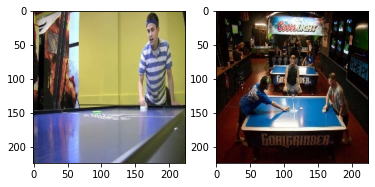

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Two images after normalize and resize (112x112):



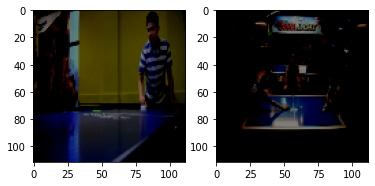

In [ ]:
def show_images(imageFolder, image_amount = 2):
        '''This function receive ImageFolder and amount ouf images to show.'''
        loader = DataLoader(imageFolder, batch_size = image_amount, shuffle = False)
        images, labels = next(iter(loader))
        f, axarr = plt.subplots(1, image_amount)
        for i in range(image_amount):
                tmp = np.transpose(images[i].squeeze(0).detach().numpy(), (1, 2, 0))
                axarr[i].imshow(tmp)
        plt.show()


image_example = ImageFolder('/content/gdrive/My Drive/Colab Notebooks/DeepProject/data/train',transform = transforms.ToTensor())
print("Two images before normalize and resize (224x224):\n")
show_images(image_example)
print("\nTwo images after normalize and resize (112x112):\n")
show_images(train_set)





In this part of the project we avoided doing data augmentation because we already have enough data to train the model.

Even tough, we dedicated a full part of the project to check and emphesize the effect of data augmentation.

##Part B - Models Comparison

In this part we will take 6 models:
1. 4 CNN layers and 2 FC layers
2. 2 CNN layers and 2 FC layers
3. resnet-34 [1]
4. resnet-50 [1]
5. EfficientNetB1 [2]
6. AlexNet [3]

For each model we will adjust the hyperparameters in order to get the best results as possible.

During the search of the hyper-parameters of each model we tried lot of diffrent hyper-parameters combinations. Between every 2 combinations we usually only changed single parameter. For the sake of simplicity we show only three combinations (that represent the searching proccess) and results of each model.

Afterwords, we will compare the best versions of each model in order to find the best model to continue with.

References:


[1] K. He, X. Zhang, S. Ren, and J. Sun. Deep residual learning for image recognition. arXiv preprint arXiv:1512.03385,2015.

[2] Mingxing Tan, Quoc V. Le, EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. arXiv preprint arXiv:1905.11946,2020.

[3] A. Krizhevsky, I. Sutskever, and G. E. Hinton. Imagenet classification with deep convolutional neural networks. In Advances in neural information processing systems,pages1097–1105,2012.

Here are some functions we will use along this part in order to comapre the models:

In [ ]:
num_classes = 73

In [ ]:
def evaluation(dataloader, model, lossFlag = False, max_iters = 30):
    '''this function takes a model and a data loader and returns the accuracy of 
    the data on the model. if the lossFlag=True, it also returns the loss calculated 
    on the first batch'''
    total, correct = 0, 0
    loss_fn = nn.CrossEntropyLoss()       #CrossEntropy Criteria
    loss = 0
    iter = 0
    for data in dataloader:
        if iter > max_iters:
            break
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)     #Sent to GPU
        outputs = model(inputs)               
        if lossFlag:
            lossFlag = False
            loss = loss_fn(outputs, labels)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        iter += 1

    return 100 * correct / total, loss

In [ ]:
def train_model(
        model,
        train_set,
        valid_set,
        batch_size = 16,
        learning_rate = 0.0001,
        weight_decay=0,
        max_iters = 100000,
        max_epochs=20,
        file = None,
        curr_idx = 100000
):
    '''this function takes a given model, train data, valid data and hyper-parameters,
    it trains the model using the Cross Entropy Loss function, it also prints the
    loss and accuracy, and it returns the losses and accuracies of the train
    set and valid set. In the end, it saves the model in the directory for future use.
     if the file is not None it also saves the model results in the text file.'''

    iterations, val_accuracies,train_accuracies, train_losses, valid_losses = [], [], [], [], []

    trainloader = DataLoader(train_set, batch_size = batch_size, shuffle =  True)
    valloader = DataLoader(valid_set, batch_size = batch_size, shuffle = True)

    for param in model.parameters():
        param.required_grad = False

    #In case of ResNet, Set the size of the fully conected to 73 outputs. 
    if model.name in ["resnt34", "resnt50"]:
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    
    #Send the model to GPU.
    model = model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    n_iters = np.ceil(len(train_set)/batch_size)*max_epochs
    iters = 0

    for epoch in range(max_epochs):
        for i, bacth in enumerate(trainloader, 0):
            iters += 1
            inputs, labels = bacth
            inputs, labels = inputs.to(device), labels.to(device)   #Send to GPU

            #Pytorch magic - predict, compute the loss, backpropegation and step.
            opt.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()

            #save the losses and accuracys.
            if iters % 50 == 0:
                trainAccuracy, _ = evaluation(DataLoader(train_set, batch_size = batch_size, shuffle =  True), model, False)
                validAccuracy, validLoss = evaluation(valloader, model,True)
                iterations.append(iters)
                val_accuracies.append(validAccuracy)
                train_accuracies.append(trainAccuracy)
                train_losses.append(loss.item())
                valid_losses.append(validLoss.item())

            #Prints the loss and accuracys.
            if iters % 100 == 0:
                print('Iteration: %d/%d, Loss: %0.2f, Validation acc: %0.2f, Train acc: %0.2f'%(iters,n_iters, loss.item(), validAccuracy, trainAccuracy))
            
            #Free memomry
            del inputs, labels, outputs
            torch.cuda.empty_cache()

            if iters >= max_iters:
                break

        print('\nEpoch: %d/%d ended\n'%(epoch+1, max_epochs))

    #saving the model details
    if file:     
        file.write(str(curr_idx)+" - "+"model=" + model.name + ", batch_size=" + str(batch_size) + ", learning_rate=" + str(
            learning_rate) + ", epochs=" + str(max_epochs) + ", weight_decay=" + str(weight_decay)+"    ====>  ")
    
    #saving the model
    torch.save(model.state_dict(), "models\\"+str(curr_idx)+model.name)                                                     
    return train_losses, valid_losses, iterations, val_accuracies, train_accuracies

In [ ]:
def plot_learning_curve(train_losses, valid_losses, iterations, val_accuracies, train_accuracies,model_name):
    """
    this function takes  the losses and accuracies of the train
    set and valid set and plot the learning curves side by side.
    """
    f, axarr = plt.subplots(1, 2)
    #First plot - Loss.
    axarr[0].set_title(model_name+" - Learning Curve:\n Loss per Iteration")
    axarr[0].plot(iterations, train_losses, label="Train")
    axarr[0].plot(iterations, valid_losses, label="Valid")
    axarr[0].legend(loc='best')
    axarr.flat[0].set(xlabel='Iterations', ylabel='Loss')

    #Second plot - accuracy.
    axarr[1].set_title(model_name+" - Learning Curve:\n Accuracy per Iteration")
    axarr[1].plot(iterations, train_accuracies, label="Train")
    axarr[1].plot(iterations, val_accuracies, label="Valid")
    axarr[1].legend(loc='best')
    axarr.flat[1].set(xlabel='Iterations', ylabel='Accuracy')

    plt.show()

In [ ]:
def get_index_model(path = 'models_results.txt'):
  '''This function find the next model index in the models_results.txt file.
  This file records all the hyper-parameters and results of the models that we ran'''
  with open(path) as f:
      for line in f:
          pass
      last_line = line
      f.close()
  return int(last_line.split(" ")[0])+1

In [ ]:
def show_figure(num_in_dir, num_in_colab):
  '''This function load an image from the google drive and show the image
  in proper size'''
  img = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/DeepProject/plots/Figure_'+str(num_in_dir)+'.png')
  plt.figure(figsize=(15,20))
  plt.axis('off')
  plt.imshow(img)
  plt.title("Figure "+str(num_in_colab))  #Add figure number to each figure.

**Because of lack of computation resources in Google Colab we trained all the models on our computer (with GPU - Geforce GTX 1080 TI).**

**In the sections below we represent the code that we ran on our computer in order to train each model.**

In every model that we trained, we **saved the model** itself and saved also the **model details** (hyper-parameters, the valid_accuracy and the train loss), also we saved for each model the **learnings curves.**
Each one of them we will load to the colab and represent them.

###Model 1 - 4 CNN layers and 2 FC layers

In [ ]:
class Four_CNN(nn.Module):
    '''This model have 4 CNN layes and two fully connect layers'''
    def __init__(self, n=5):
        super(Four_CNN, self).__init__()
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.n, kernel_size=5,  padding = int((5-1) / 2))
        self.conv2 = nn.Conv2d(self.n, 2*self.n, kernel_size=5, padding = int((5-1) / 2))
        self.conv3 = nn.Conv2d(2*self.n, 4*self.n, kernel_size=5, padding = int((5-1) / 2))
        self.conv4 = nn.Conv2d(4*self.n, 8*self.n, kernel_size=5, padding = int((5-1) / 2))
        self.fc1 = nn.Linear(int(8*n*((112-2*4)/4)**2), out_features = 100)
        self.fc2 = nn.Linear(in_features = 100, out_features = 73)
        self.name = "Four_CNN"

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=5, stride = 1)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=5, stride = 1)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride = 2)

        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride = 2)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        
        return x

In [ ]:
''' Here is the code we ran on our computer:   '''
#Get the next model index on models_results.txt file in order to record the results.
curr_idx = get_index_model()
res_file = open("models_results.txt", "a")

model = Four_CNN()

# model parameters amount
print(model.name+" number of parameters: ", str(sum(p.numel() for p in model.parameters()))+"\n")
# Train model
train_losses, valid_losses, iterations, val_accuracies, train_accuracies = train_model(model,train_set,valid_set,batch_size=64,learning_rate=0.002, weight_decay=0.0001,
                         max_iters=100000000,max_epochs=5, file = res_file, curr_idx=curr_idx)
# Plot learnung curve
plot_learning_curve(train_losses, valid_losses, iterations, val_accuracies, train_accuracies,model.name)
# Writing result to file
res_file.write("loss = "+str(train_losses[-1])[:7]+",    valid accuracy = " + str(val_accuracies[-1])[:7] + "\n")

res_file.close()

At first we put the following hyper-parameters:

*   batch_size = 64
*   learning_rate = 0.0001
*   epochs = 5
*   weight_decay = 0
*   n = 5

we derived the following results:

 loss = 3.02222,    valid accuracy = 15.8904%


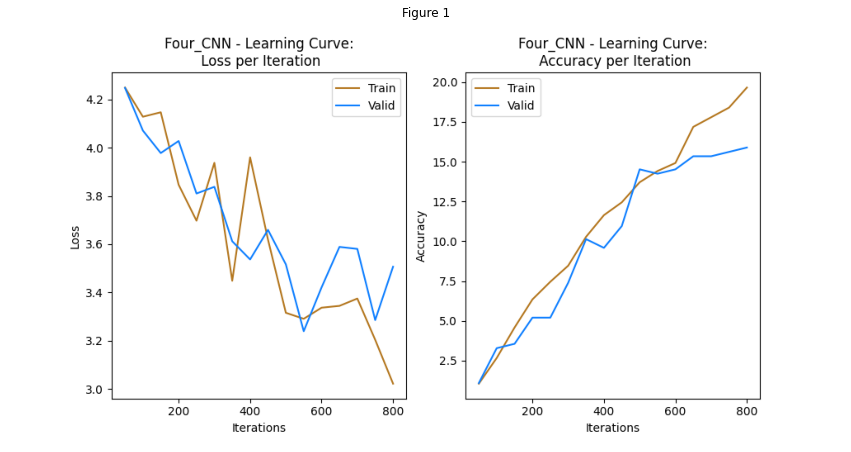

In [ ]:
show_figure(2,1)

As seen in the figure 1, it seems that **the training proccess could continue** a bit more, so in this time we **increased the number of epochs**(and also tried couple more times to change the learning rate) until we derived the following learning curve:

Hyper-parameters:

*   batch_size = 64
*   learning_rate = 0.001
*   epochs = 7
*   weight_decay = 0
*   n = 5

we derived the following results:

loss = 1.56926,    valid accuracy = 32.3287%

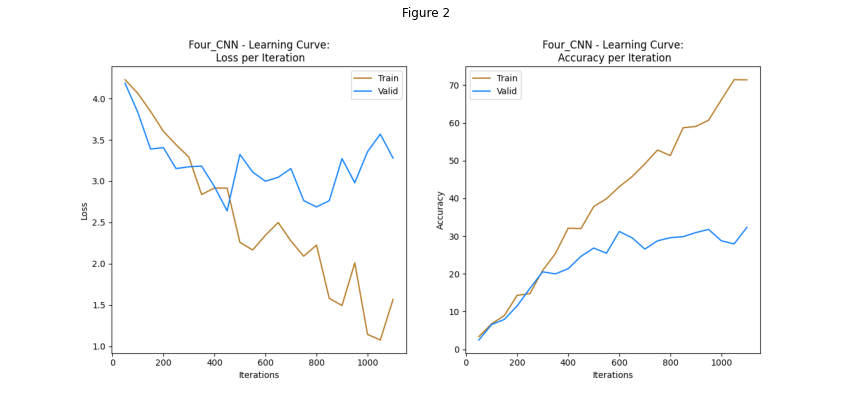

In [ ]:
show_figure(3,2)

In the previus training proccess, we arrived much better results( 32% valid accuracy as opossed to 15% before that), but as it can be seen in the curves above, we encountered an **over-fitting**.

therefore, we have had few more tries with different hyper-params until we derived the best result with the  following hyper-parameters:

*   batch_size = 64
*   learning_rate = 0.001
*   epochs = 5
*   weight_decay = 0.0001
*   n = 5

we derived the following results:

loss = 2.54062,    valid accuracy = 33.1506%


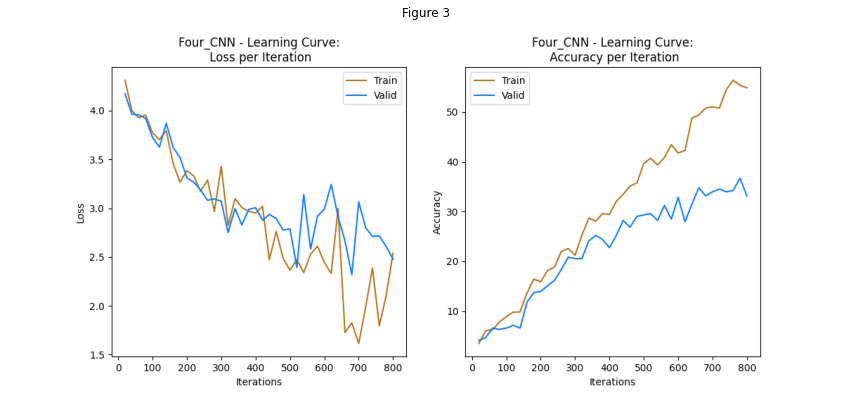

In [ ]:
show_figure(15,3)

###Model 2 - 2 CNN layers and 2 FC layers

In [ ]:
class two_CNN(nn.Module):
    '''This model have two CNN layes and two fully connected layes'''
    def __init__(self, n=100):
        super(two_CNN, self).__init__()
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.n, kernel_size=5,  padding = int((5-1) / 2))
        self.conv2 = nn.Conv2d(self.n, 2*self.n, kernel_size=5, padding = int((5-1) / 2))
        self.fc1 = nn.Linear(int(2*n*((112-2)/5)**2), out_features = 100)
        self.fc2 = nn.Linear(in_features = 100, out_features = 73)
        self.name = "two_CNN"

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=5, stride=1, padding=1)(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=5, stride =5)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        return x

In [ ]:
''' Here is the code we ran on our computer:   '''
#Get the next model index on models_results.txt file in order to record the results.
curr_idx = get_index_model()
res_file = open("models_results.txt", "a")

model = two_CNN()

# model parameters amount
print(model.name+" number of parameters: ", str(sum(p.numel() for p in model.parameters()))+"\n")
# Train model
train_losses, valid_losses, iterations, val_accuracies, train_accuracies = train_model(model,train_set,valid_set,batch_size=64,learning_rate=0.0005, weight_decay=0.01,
                         max_iters=100000000,max_epochs=5, file = res_file, curr_idx=curr_idx)
# Plot learnung curve
plot_learning_curve(train_losses, valid_losses, iterations, val_accuracies, train_accuracies,model.name)
# Writing result to file
res_file.write("loss = "+str(train_losses[-1])[:7]+",    valid accuracy = " + str(val_accuracies[-1])[:7] + "\n")

res_file.close()

At first we put the following hyper-parameters:

*   batch_size = 64
*   learning_rate = 0.001
*   epochs = 5
*   weight_decay = 0
*   n = 50

we derived the following results:

loss = 2.84589,    valid accuracy = 27.1232


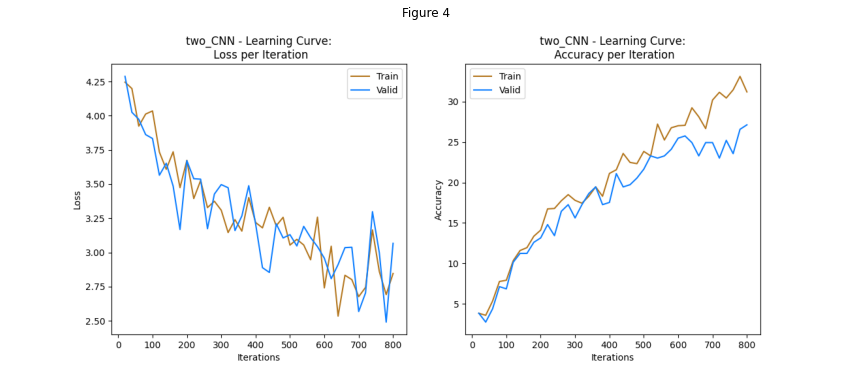

In [ ]:
show_figure(39,4)

It seems from the learning curve that the training process do not suffer from over-fitting. Hence, we tried to increase the complexity of the model by increasing the output channels (n).
Therefore, we put the following hyper-parameters:

*   batch_size = 64
*   learning_rate = 0.001
*   epochs = 5
*   weight_decay = 0
*   n = 100

we derived the following results:

loss = 2.02342,    valid accuracy = 32.3287


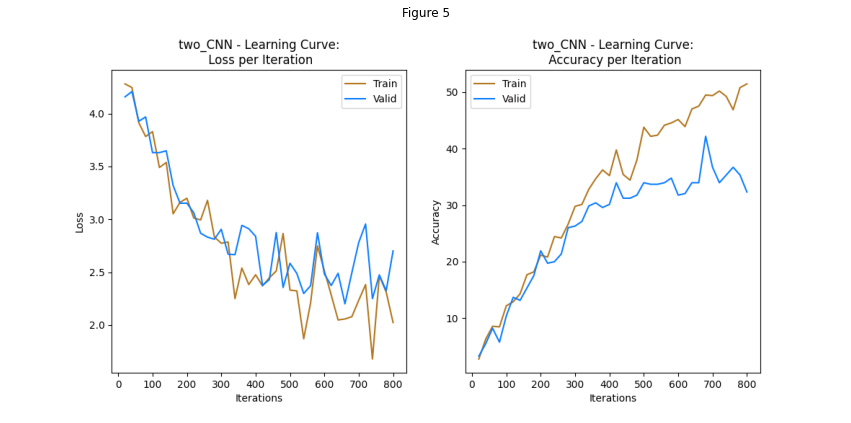

In [ ]:
show_figure(40,5)

In the previus training proccess, we arrived better results( 32% valid accuracy as opossed to 27% before that), but as it can be seen in the curves above, we encountered an **over-fitting**.

therefore, we have had few more tries with different hyper-params until we derived the best result with the  following hyper-parameters:


*   batch_size = 64
*   learning_rate = 0.0005
*   epochs = 5
*   weight_decay = 0.01
*   n = 100

we derived the following results:

loss = 2.31207,    valid accuracy = 42.1917

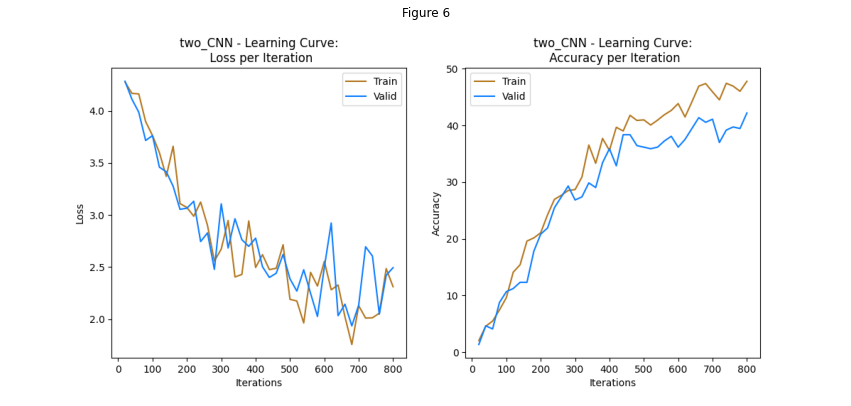

In [ ]:
show_figure(48,6)

###Model 3 - resnet-34

In [ ]:
''' Here is the code we ran on our computer:   '''
#Get the next model index on models_results.txt file in order to record the results.
curr_idx = get_index_model()
res_file = open("models_results.txt", "a")

model = models.resnet34(pretrained= True)
model.name = "resnet34"

# model parameters amount
print(model.name+" number of parameters: ", str(sum(p.numel() for p in model.parameters()))+"\n")
# Train model
train_losses, valid_losses, iterations, val_accuracies, train_accuracies = train_model(model,train_set,valid_set,batch_size=96,learning_rate=0.0001, weight_decay=0.0001,
                         max_iters=100000000,max_epochs=4, file = res_file, curr_idx=curr_idx)
# Plot learnung curve
plot_learning_curve(train_losses, valid_losses, iterations, val_accuracies, train_accuracies,model.name)
# Writing result to file
res_file.write("loss = "+str(train_losses[-1])[:7]+",    valid accuracy = " + str(val_accuracies[-1])[:7] + "\n")

res_file.close()

At first we put the following hyper-parameters:

*   batch_size = 16
*   learning_rate = 0.0003
*   epochs = 3
*   weight_decay = 0

we derived the following results:

loss = 0.65684,    valid accuracy = 77.2602


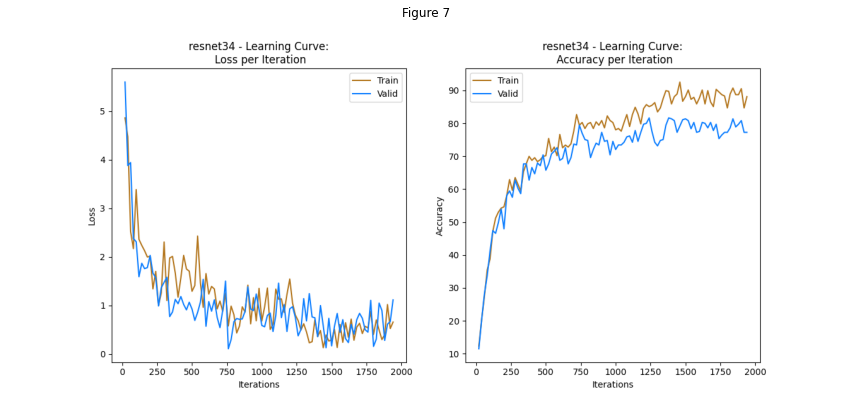

In [ ]:
show_figure(16,7)

In the figure above, we saw that the curve was very **noisy**, so as before we decided to **increase the batch size**.

In addition, we noticed **the loss curve dropped dramtically at the start** of the training, so we conclude we need to try **decrese the learning rate**, and because of that we increased the amount of epochs.

we trained the model few times more with (more or less) the following hyper-parameters:

*   batch_size = 64
*   learning_rate = 3e-5
*   epochs = 6
*   weight_decay = 0

we derived the following results:

loss = 0.11801,    valid accuracy = 78.6301

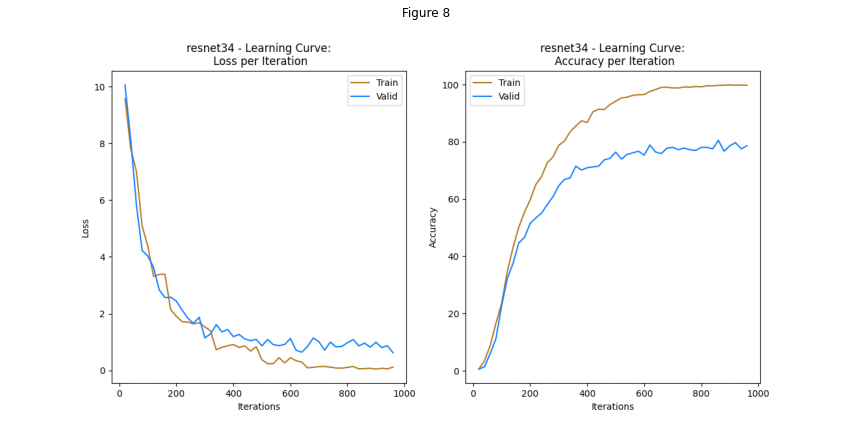

In [ ]:
show_figure(17,8)

Afterwards, we tried couple more trainings with different hyper-params, until we got the following results with the following hyper-parameters:

*   batch_size = 64
*   learning_rate = 0.0001
*   epochs = 4
*   weight_decay = 0

we derived the following results:

loss = 0.01620,    valid accuracy = 86.5753

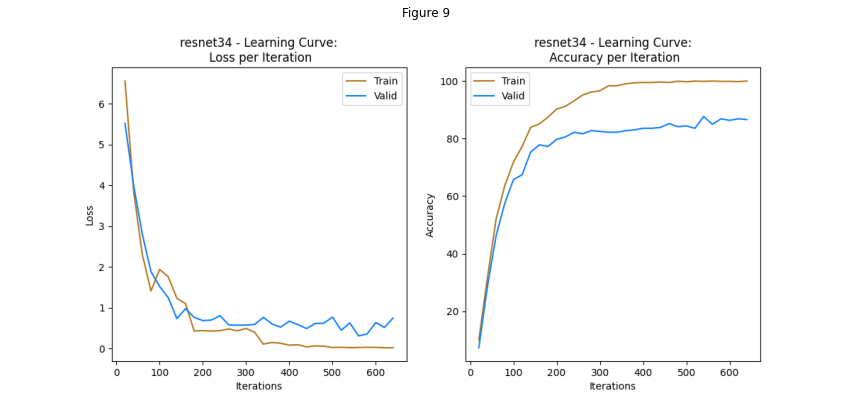

In [ ]:
show_figure(20,9)

###Model 4 - resnet-50

In [ ]:
''' Here is the code we ran on our computer:   '''
#Get the next model index on models_results.txt file in order to record the results.
curr_idx = get_index_model()
res_file = open("models_results.txt", "a")

model = models.resnet50(pretrained= True)
model.name = "resnet50"

# model parameters amount
print(model.name+" number of parameters: ", str(sum(p.numel() for p in model.parameters()))+"\n")
# Train model
train_losses, valid_losses, iterations, val_accuracies, train_accuracies = train_model(model,train_set,valid_set,batch_size=64,learning_rate=0.0001, weight_decay=0.5,
                         max_iters=100000000,max_epochs=3, file = res_file, curr_idx=curr_idx)
# Plot learnung curve
plot_learning_curve(train_losses, valid_losses, iterations, val_accuracies, train_accuracies,model.name)
# Writing result to file
res_file.write("loss = "+str(train_losses[-1])[:7]+",    valid accuracy = " + str(val_accuracies[-1])[:7] + "\n")

res_file.close()

At first we put the following hyper-parameters:

*   batch_size = 16
*   learning_rate = 0.0002
*   epochs = 2
*   weight_decay = 0

we derived the following results:

loss = 0.95217,    valid accuracy = 79.1780%

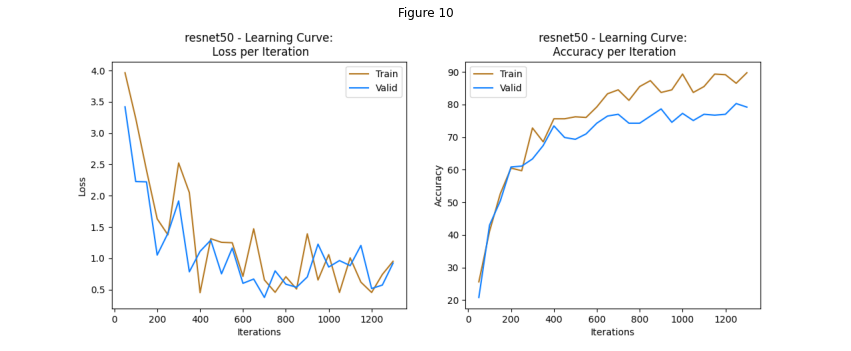

In [ ]:
show_figure(6,10)

As it seems above, the learning curve looks find except one thing, it is a bit **noisy**. Therfore, **we increased the batch size** and trained it again with the following hyper-parameters:


*   batch_size = 32
*   learning_rate = 0.0001
*   epochs = 2
*   weight_decay = 0

we derived the following results:

loss = 0.25641,    valid accuracy = 85.4794%

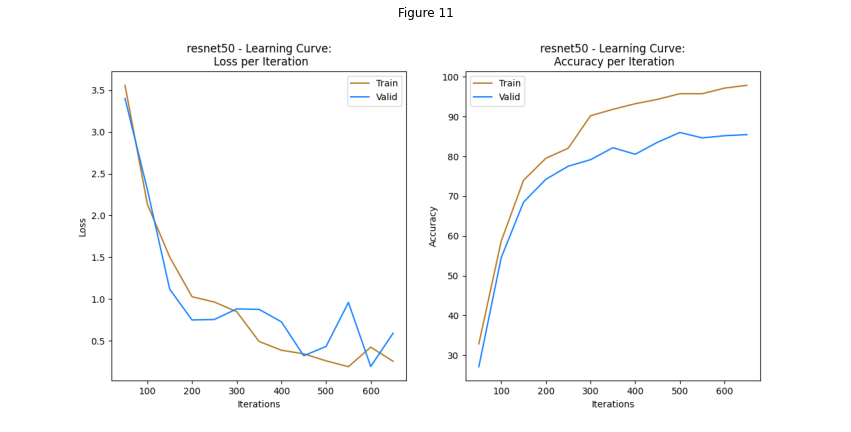

In [ ]:
show_figure(8,11)

The training results were better then before (with more valid accuracy) but it was still a little bit **noisy** and maybe a little bit overfit. Hence we **incresed the batch even more** and put a little bit weight decay for the purpose of reducing over-fitting. 

we trained it again with the following hyper-parameters:

*   batch_size = 64
*   learning_rate = 0.0001
*   epochs = 2
*   weight_decay = 3e-5

we derived the following results:

loss = 0.34079,    valid accuracy = 86.5753%

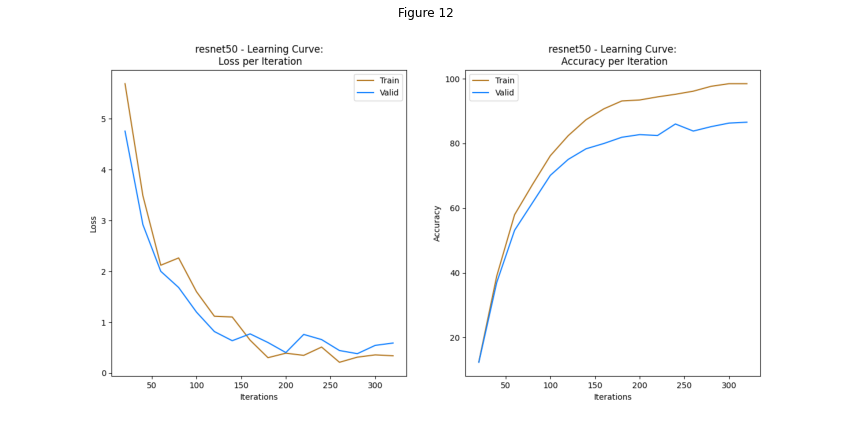

In [ ]:
show_figure(10,12)

###Model 5 - EfficientNetB1

In [ ]:
''' Here is the code we ran on our computer:   '''
#Get the next model index on models_results.txt file in order to record the results.
curr_idx = get_index_model()
res_file = open("models_results.txt", "a")

model = models.efficientnet_b1(pretrained=True)
model.name = "efficientnet_b1"

# model parameters amount
print(model.name+" number of parameters: ", str(sum(p.numel() for p in model.parameters()))+"\n")
# Train model
train_losses, valid_losses, iterations, val_accuracies, train_accuracies = train_model(model,train_set,valid_set,batch_size=64,learning_rate=0.0002, weight_decay=0,
                         max_iters=100000000,max_epochs=5, file = res_file, curr_idx=curr_idx)
# Plot learnung curve
plot_learning_curve(train_losses, valid_losses, iterations, val_accuracies, train_accuracies,model.name)
# Writing result to file
res_file.write("loss = "+str(train_losses[-1])[:7]+",    valid accuracy = " + str(val_accuracies[-1])[:7] + "\n")

res_file.close()

At first we put the following hyper-parameters:

*   batch_size = 32
*   learning_rate = 0.0003
*   epochs = 3
*   weight_decay = 0

we derived the following results:

loss = 0.10994,    valid accuracy = 86.3013%

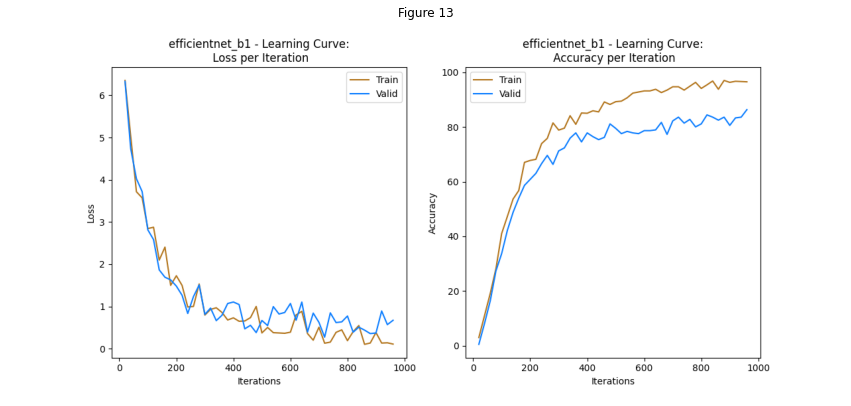

In [ ]:
show_figure(25,13)

The figure present a good learning curve, except the loss curve dropped a little bit too dramtically at the start of the training. so we decided to try decrese the learning rate. we did few more trainings with different hyper-params.

In one of the tries we trained the model again the following hyper-parameters:

*   batch_size = 64
*   learning_rate = 0.0001
*   epochs = 3
*   weight_decay = 0

we derived the following results:

loss = 0.96303,    valid accuracy = 72.6027%

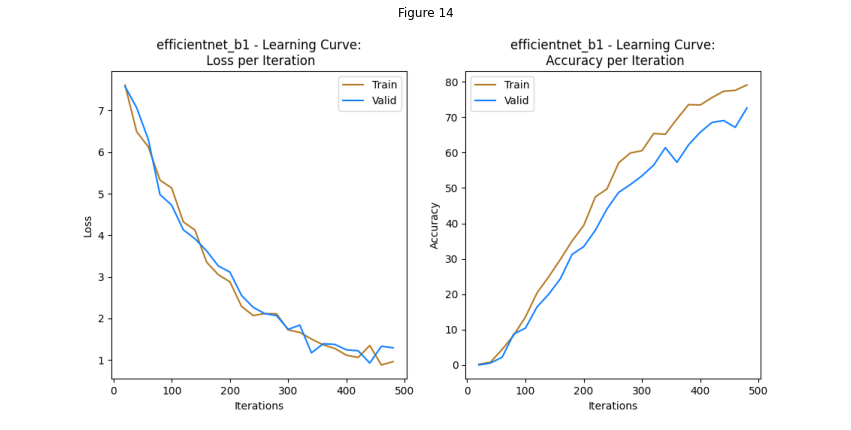

In [ ]:
show_figure(26,14)

In the previus figure, we see that the **learning proccess stopped slightly too early**. Hence, we tried to **increase the number of epochs** and also played slightly with the learning rate until we eventually tried the model with
with the following hyper-parameters:

*   batch_size = 64
*   learning_rate = 0.0002
*   epochs = 5
*   weight_decay = 0

we derived the following results:

loss = 0.07828,    valid accuracy = 86.8493%

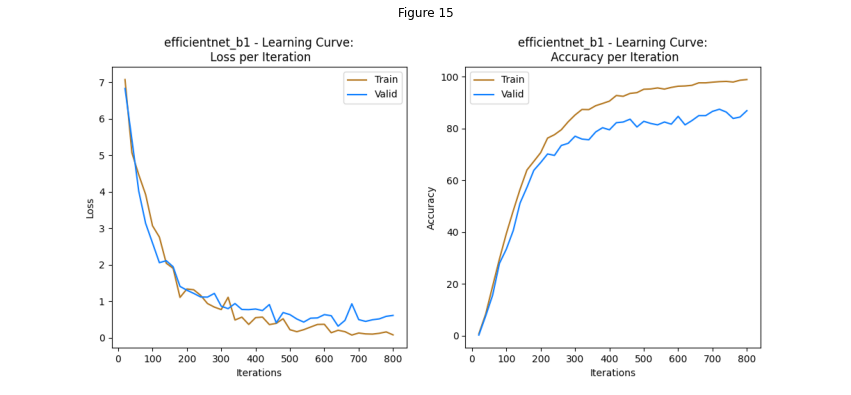

In [ ]:
show_figure(28,15)

###Model 6 - AlexNet

In [ ]:
''' Here is the code we ran on our computer:   '''
#Get the next model index on models_results.txt file in order to record the results.
curr_idx = get_index_model()
res_file = open("models_results.txt", "a")

model = models.alexnet(pretrained=True)
model.name = "alexnet"

# model parameters amount
print(model.name+" number of parameters: ", str(sum(p.numel() for p in model.parameters()))+"\n")
# Train model
train_losses, valid_losses, iterations, val_accuracies, train_accuracies = train_model(model,train_set,valid_set,batch_size=64,learning_rate=0.0002, weight_decay=0,
                         max_iters=100000000,max_epochs=5, file = res_file, curr_idx=curr_idx)
# Plot learnung curve
plot_learning_curve(train_losses, valid_losses, iterations, val_accuracies, train_accuracies,model.name)
# Writing result to file
res_file.write("loss = "+str(train_losses[-1])[:7]+",    valid accuracy = " + str(val_accuracies[-1])[:7] + "\n")

res_file.close()

At first we put the following hyper-parameters:

*   batch_size = 16
*   learning_rate = 0.0001
*   epochs = 5
*   weight_decay = 0

we derived the following results:

loss = 0.61486,    valid accuracy = 68.7671


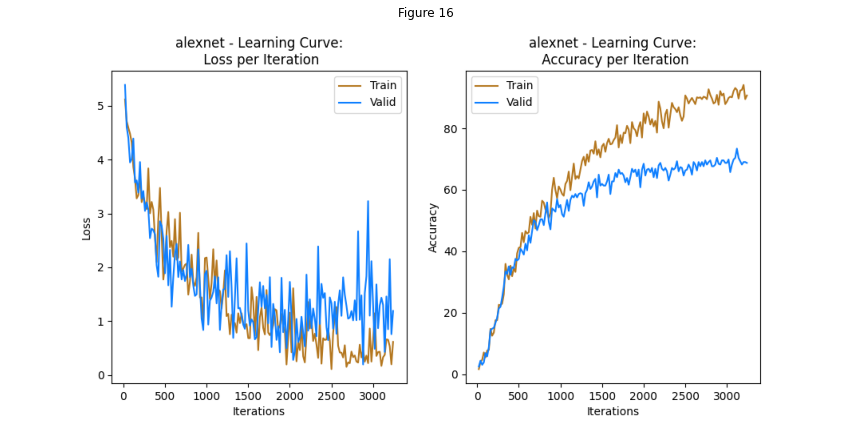

In [ ]:
show_figure(31,16)

In the figure above, we saw that the curve was very **noisy**, so as before we decided to **increase the batch size**.

We trained the model few times more with (more or less) the following hyper-parameters:

*   batch_size = 64
*   learning_rate = 5e-5
*   epochs = 4
*   weight_decay = 0

we derived the following results:

loss = 1.21323,    valid accuracy = 62.4657

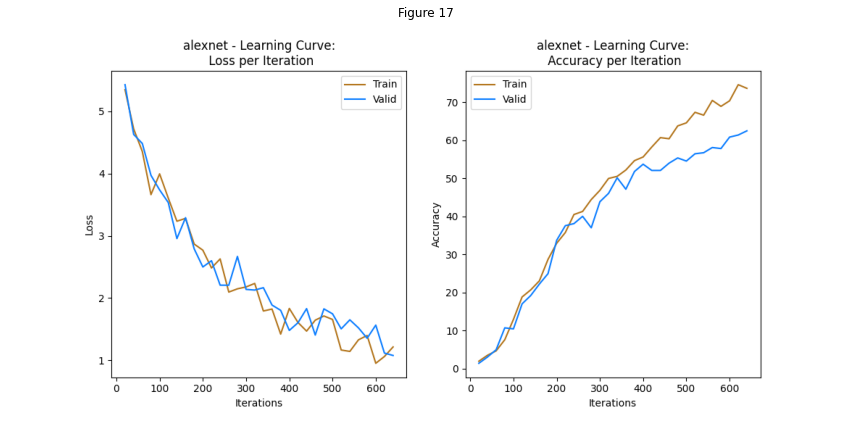

In [ ]:
show_figure(33,17)

As seen in the figure above, the increase of the batch size reduced the noise but the validation accuracy of the model reduced as well. Therefore, we tried to tuned the hyper-parameters and finally we found that the following parameters are the best.

We trained the model few times more with (more or less) the following hyper-parameters:

*   batch_size = 64
*   learning_rate = 0.0002
*   epochs = 5
*   weight_decay = 0.0005

we derived the following results:

loss = 0.67351,    valid accuracy = 73.1506

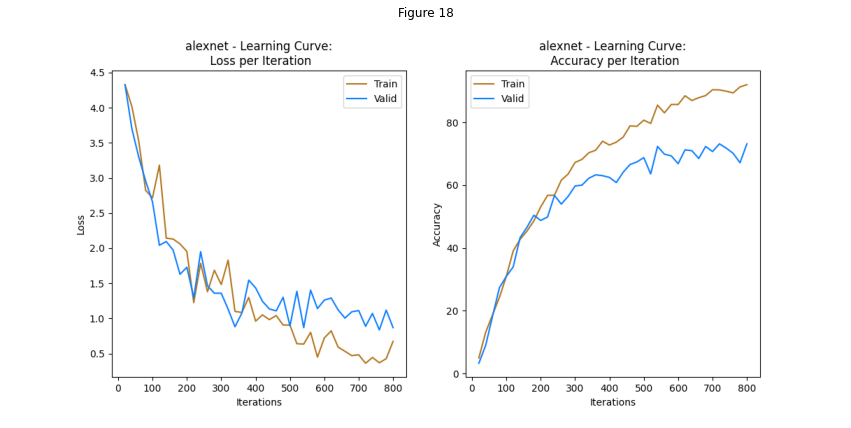

In [ ]:
show_figure(37,18)

###All models results

In [ ]:
'''In this part we load the best model and predict the test set'''
from torchvision import models
PATH = '/content/gdrive/My Drive/Colab Notebooks/DeepProject/models/'
models = [(Four_CNN(),'15Four_CNN'), (two_CNN(),'48two_CNN'), (models.resnet34(),'17resnet34'), (models.resnet50(),'10resnet50'), (models.efficientnet_b1(),'28efficientnet_b1'), (models.alexnet(),'37alexnet')]

for i, (model, path) in enumerate(models):
  #Load the best model from google drive.
  model.load_state_dict(torch.load(PATH+path,map_location=torch.device('cpu')))
  #Send model to GPU
  model = model.to(device)
  testloader = DataLoader(test_set, batch_size = 16, shuffle = True)
  #Perform evaluation on the test set
  acc, _ = evaluation(testloader, model, False)
  #Print the performance of each model
  print("model", i+1, path[2:] ,'('+str(sum(p.numel() for p in model.parameters()))+' parameters)',': Test Accuarcy on final model: %0.4f' % acc)
  torch.cuda.empty_cache()

model 1 Four_CNN (2738173 parameters) : Test Accuarcy on final model: 35.8904
model 2 two_CNN (10195273 parameters) : Test Accuarcy on final model: 43.0137
model 3 resnet34 (21797672 parameters) : Test Accuarcy on final model: 81.3699
model 4 resnet50 (25557032 parameters) : Test Accuarcy on final model: 85.4795
model 5 efficientnet_b1 (7794184 parameters) : Test Accuarcy on final model: 84.1096
model 6 alexnet (61100840 parameters) : Test Accuarcy on final model: 71.2329


### Part B - conclusions

In this part we trained 6 diffrent model architectures, for each model we optimaized the training hyper-parameters and compared the performances of the models.
Our main conclusions from this part:

* The model's architectures that made by us (i.e. "Two_CNN" and "Four_CNN") can not achive the same level of performance as the pretrained "of the shelf" architectures. this conclusion emphesize the greatness of these complicated architectures.

* The ResNet50 model achived the best performance of all other models. This models is highly complicated with 50 residual layers and some fully connected layers. Therefore require high computatinaly resouces to train.

* The number of model wights (parameters) is not necessarily indicate the model`s performance - Alexnet contains X8 the amount of wights then EfficientNet but achived 13% less accuracy.

* Deep learning and especially working with images is highly computaion demanding. All the above work could not be implemanted on colab resources. Therefore we now appriciate more than ever the parallel compution that GPUs provide, Working with good GPU boost our training process dramatically.

* Although there are 73 classes we managed to overcome the classification challenge and able to achive 85% accuracy.

##part C - Data Augmentation

In this part we will continue only with the Resnet50 architechture which achived the best results in the previus part.

We will demonstrate the Data Augmentation technique by using 5 different transforms and comparing them.

We will compare 8 different trainning processes that deffer with different training datasets:

* **Original-100%** - all the training set - 10,416 images.
* **orignal-50%** - 50% precent of the original training set (taking at random) - 5,208 images.
* **Gaussian Blur** - original (5,208 images), 5,208 images which are Gaussian Blur of the "orignal-50%" - 10,416 images.
* **Random Rotation** - original (5,208 images), 5,208 images which are Random Rotation of the "orignal-50%" - 10,416 images.
* **Color Jitter** - original (5,208 images), 5,208 images which are Color Jitter of the "orignal-50%" - 10,416 images.
* **Random Affine** - original 5,208 images), 5,208 images which are Random Affine of the"orignal-50%" - 10,416 images.
* **Random Apply** - original (5,208 images), 5,208 images that each one is a Random choose of 2 transforms of an image from the "original-50%" - 10,416 images.
* **All Augments** - original (5,208 images), 5,208 images that each one is the results of all the previus transforms performed on image from the "orignal-50%" - 10,416 images.


*Note that:

The first dataset (i.e. "original-100%") is using the entire original training set.

The second dataset (i.e. "original-50%") is using subset of the training set in size of 5,208 images.

The 6 datasets after are 10,416 images each. each one of them is containing half (5,208) of the training data set and another 5,208 augmented images generated from the first half.




We ran the following code in order to make all the different datasets:

In [ ]:
'''This dict contain transforms with all the augments described above'''
transform_dict = {
    'original': transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((112,112)),                               
            transforms.Normalize((0.5,0.5,0.5), (1, 1, 1))]),
    'ColorJitter': transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((112,112)),                              
                transforms.Normalize((0.5,0.5,0.5), (1, 1, 1)),
                transforms.ColorJitter(brightness=.5, hue=.3)]),
    'GaussianBlur': transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((112,112)),                              
                transforms.Normalize((0.5,0.5,0.5), (1, 1, 1)),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))]),
    'RandomApply': transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((112,112)),                               
                transforms.Normalize((0.5,0.5,0.5), (1, 1, 1)),
                transforms.RandomApply(transforms=[transforms.RandomHorizontalFlip(p=1), transforms.RandomVerticalFlip(p=1)], p=2/5),
                transforms.RandomApply(transforms=[transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=2/5),
                transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=.5, hue=.3)], p=2/5),
                transforms.RandomApply(transforms=[transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))], p=2/5),
                transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(0, 180))], p=2/5)]),
    'RandomRotation': transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((112,112)),                               
                transforms.Normalize((0.5,0.5,0.5), (1, 1, 1)),
                transforms.RandomRotation(degrees=(0, 180))]),
    'AllAugments': transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((112,112)),                               
                transforms.Normalize((0.5,0.5,0.5), (1, 1, 1)),
                transforms.RandomRotation(degrees=(0, 180)),
                transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                transforms.RandomApply(transforms=[transforms.RandomHorizontalFlip(p=1), transforms.RandomVerticalFlip(p=1)], p=1),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.ColorJitter(brightness=.5, hue=.3)]),
    'RandomAffine': transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((112,112)),                               
            transforms.Normalize((0.5,0.5,0.5), (1, 1, 1)),
            transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))])
}

In [ ]:
def make_augmented(train_set, original_images_fraction):
    '''This function create all the augmented data sets for each augment technique'''
    #Split len is the fraction from the original train set to be taken.
    split_len = int(1/original_images_fraction * len(train_set))
    train_subset, _ = torch.utils.data.random_split(train_set,[split_len, len(train_set) - split_len],
                        generator=torch.Generator().manual_seed(42))
    
    augments_lst = ['original-'+str(100//original_images_fraction)+'%', 'RandomApply', 'ColorJitter', 'RandomAffine', 'GaussianBlur',  'RandomRotation', 'AllAugments']
    train_subset.dataset.transform = transform_dict['original']

    for agmt in augments_lst:
        #Make library for each augment. 
        os.mkdir("data\\data_augmentation\\"+agmt)
        for key in list(train_set.class_to_idx.keys()):
            os.mkdir("data\\data_augmentation\\"+agmt+"\\"+str(key))
        idxs = list(np.zeros(73,dtype=int))

        #Save the subset of the train set
        for data in train_subset:
            image, label = data
            label_str = list(train_subset.dataset.class_to_idx.keys())[label]
            save_image(image, "data\\data_augmentation\\"+agmt+"\\" + label_str + "\\image" + str(idxs[label])+".png")
            idxs[label] += 1

        #In case of original we would like to save only the original images 
        #witout any augmentation.
        if agmt == 'original-'+str(100//original_images_fraction)+'%':
            continue

        # Add augmented data based on the subset.
        agmt_data = copy(train_subset)
        agmt_data.dataset = copy(train_set)
        agmt_data.dataset.transform = transform_dict[agmt]
        for data in agmt_data:
            image, label = data
            label_str = list(agmt_data.dataset.class_to_idx.keys())[label]
            save_image(image, "data\\data_augmentation\\" + agmt + "\\" + label_str + "\\image" + str(idxs[label])+".png")
            idxs[label] += 1

#Generate 50% augmented data sets.
make_augmented(ImageFolder('/content/gdrive/My Drive/Colab Notebooks/DeepProject/data/train'), 2)

Here we demonstrate one image from each augmented data set we created:

original:



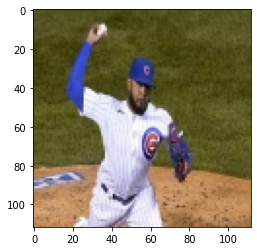



RandomApply:



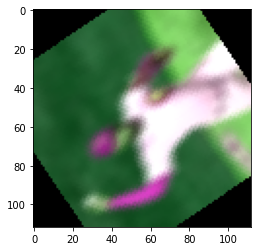



ColorJitter:



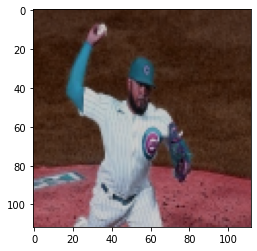



RandomAffine:



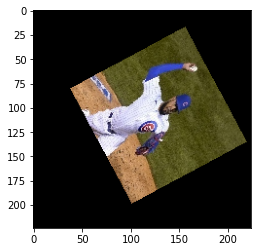



GaussianBlur:



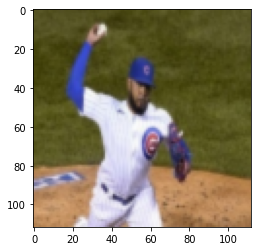



RandomRotation:



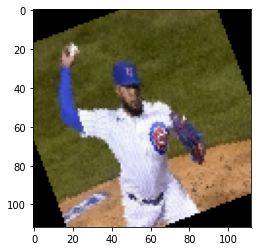



AllAugments:



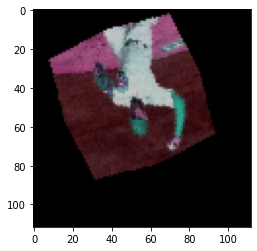

In [ ]:
def show_img_sample():
    '''This function show examples from each augmentation technique'''
    augments_lst = ['original-'+str(100//2)+'%', 'RandomApply', 'ColorJitter', 'RandomAffine', 'GaussianBlur',  'RandomRotation','AllAugments']
    for agmt in augments_lst:
        if agmt != 'original-'+str(100//2)+'%':
            print('\n\n'+agmt+':\n')          
            image = mpimg.imread("/content/gdrive/My Drive/Colab Notebooks/DeepProject/data/data_augmentation/" + agmt + "//" + "//image" + str(128)+".png")
            plt.imshow(image)
            plt.show()
        else:
            print(agmt+':\n')          
            image = mpimg.imread("/content/gdrive/My Drive/Colab Notebooks/DeepProject/data/data_augmentation/" + agmt + "//" + "//image" + str(47)+".png")
            
            plt.imshow(image)
            plt.show()

show_img_sample()

We trained the ResNet50 model on each data set that we described above.

In [ ]:
def agmt_train(original_images_fraction):
    ''' We ran the following code in our computer in order to train the ResNet50 model
    on each augmented data set'''

    valid_set = ImageFolder('data\\valid', transform = transform_dict['original'])

    # graphs settings
    f, axarr = plt.subplots(1, 2)
    axarr[0].set_title("resnet50" + " Data augmentaion compare\nLearning Curve: Loss per Iteration")
    axarr[1].set_title("resnet50" + " Data augmentaion compare\nAccuracy per Iteration")
    batch_size = 64
    learning_rate = 0.0001
    weight_decay = 3e-5
    max_iters = 160
    max_epochs = 15

    model = models.resnet50(pretrained= True)
    model.name = "ResNet50"
    
    #Training on the full train set
    train_set = ImageFolder("data\\train", transform= transform_dict['original'])
    train_losses, valid_losses, iterations, val_accuracies, train_accuracies = train_model(model, train_set,
      valid_set, batch_size=batch_size, learning_rate=learning_rate, weight_decay=weight_decay, max_iters=max_iters, max_epochs=max_epochs, file=None,
        curr_idx=0)
    
    #Plots
    axarr[0].plot(iterations, valid_losses, label='original-'+str(2*100//original_images_fraction)+'%')
    axarr[1].plot(iterations, val_accuracies, label='original-'+str(2*100//original_images_fraction)+'%')

    augments_lst = ['original-'+str(100//original_images_fraction)+'%', 'GaussianBlur', 'RandomRotation', 'ColorJitter', 'RandomAffine', 'RandomApply', 'AllAugments']
    for agmt in augments_lst:
        print(agmt)
        print(batch_size, learning_rate, weight_decay , max_iters, max_epochs)
        model = models.resnet50(pretrained= True)
        model.name = "ResNet50"
        #Load the augmented data
        train_set = ImageFolder("data\\data_augmentation\\"+agmt, transform= transform_dict['original'])
        #Training on augmented data
        train_losses, valid_losses, iterations, val_accuracies, train_accuracies = train_model(model, train_set,
            valid_set, batch_size=batch_size, learning_rate=learning_rate, weight_decay=weight_decay, max_iters=max_iters, max_epochs=max_epochs, file=None,
            curr_idx=0)
        #Plots for each augment a plot.
        axarr[0].plot(iterations, valid_losses, label=agmt)
        axarr[1].plot(iterations, val_accuracies, label=agmt)


    axarr[0].legend(loc='best')
    axarr.flat[0].set(xlabel='Iterations', ylabel='Loss')
    axarr[1].legend(loc='best')
    axarr.flat[1].set(xlabel='Iterations', ylabel='Accuracy')
    plt.show()

#Train 50% augmented data
agmt_train(2)


 The validation accuracy and loss of each model (ResNet50 trained on each augmented data set):



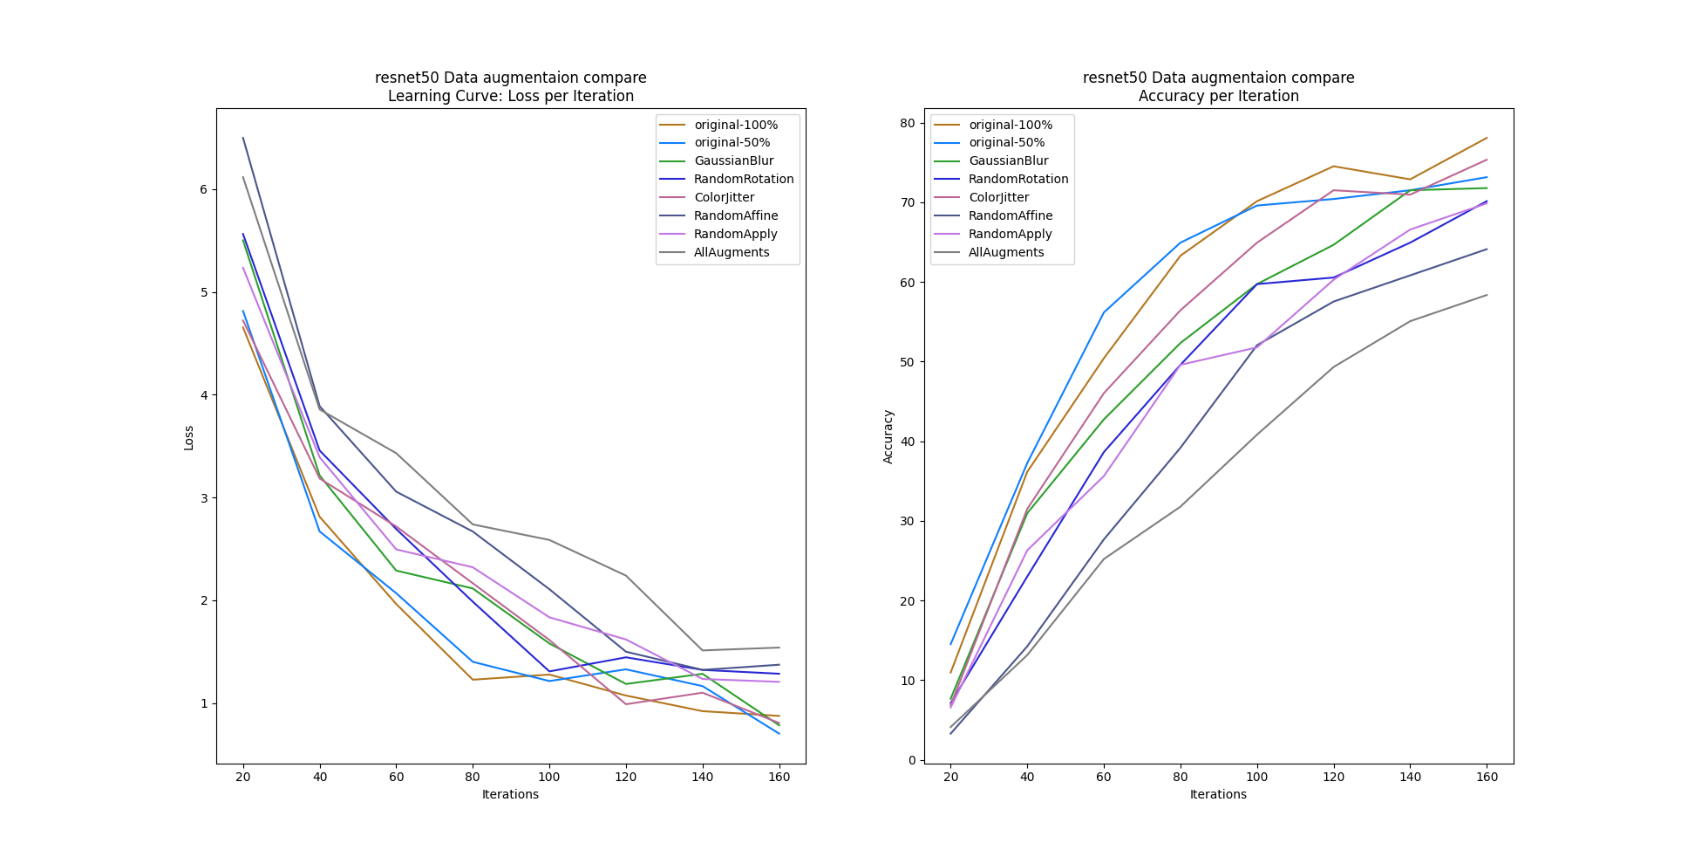

In [ ]:
#Load the results figure from google drive.
print("\n The validation accuracy and loss of each model (ResNet50 trained on each augmented data set):\n")
img = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/DeepProject/plots/Figure_'+str(105)+'.png')
plt.figure(figsize=(30,50))
plt.axis('off')
plt.imshow(img)

The results from the above figure:

* Most of the models that trained on the augmented data set did not achived better result then the original-50% data set that its were generated from. In other words, the data augmentation technique did not contributed to the model's accuracy.

* The "Original-50%" (which contains half of the training data set) achived almost similar results to the "Original-100%" (which contains the entire training data set) in term of accuracy and loss.

* The "AllAugments" data set which is combination of all the rest augmentation techniques is the worst data set for training the model. This data set achived the lowest accuracy and the highest loss result.



From the results above, we can conclude:

* Due to the lack of difference in the results between the "original-50%" and "original-100%", we think that 50% of the data is enough data sampels for training the model properly. 

* The previous conclusion causes us to conclude that the reason of uncontribution of the data augmentations to the training results is the fact that the data set was already big enough, and the addition of the augmented data wasn't really nessecery.

Hence, In order to demonstare the advantage of data augmentation technique we need to take a smaller subset of our training data set. Threrfore, We will take 10% of the training data and then double the size (to total of 20% of the training set) with diffrent augmentations that we described above.


In this section we return on the same augmentation procdure but with 10% of the training data.
We will compare 8 different trainning processes that deffer with different training datasets:

* **Original-20%** - all the training set - 2082 images.
* **orignal-10%** - 10% precent of the original training set (taking at random) - 1041 images.
* **Gaussian Blur** - original (1041 images), 1041 images which are Gaussian Blur of the "orignal-10%" - 2082 images.
* **Random Rotation** - original (1041 images), 1041 images which are Random Rotation of the "orignal-10%" - 2082 images.
* **Color Jitter** - original (1041 images), 1041 images which are Color Jitter of the "orignal-10%" - 2082 images.
* **Random Affine** - original 1041 images), 1041 images which are Random Affine of the"orignal-10%" - 2082 images.
* **Random Apply** - original (1041 images), 1041 images that each one is a Random choose of 2 transforms of an image from the "original-10%" - 2082 images.
* **All Augments** - original (1041 images), 1041 images that each one is the results of all the previus transforms performed on image from the "orignal-10%" - 2082 images.


*Note that:

The first dataset (i.e. "original-20%") is using the entire original training set.

The second dataset (i.e. "original-10%") is using subset of the training set in size of 2082 images.

The 6 datasets after are 10,416 images each. each one of them is containing half (5,208) of the training data set and another 5,208 augmented images generated from the first half.


In [ ]:
#Generate augmented data based on 10% of the train set and train the ResNet50.
make_augmented(ImageFolder('/content/gdrive/My Drive/Colab Notebooks/DeepProject/data/train'), 10)
agmt_train(10)


 The validation accuracy and loss of each model (ResNet50 trained on each augmented data set):



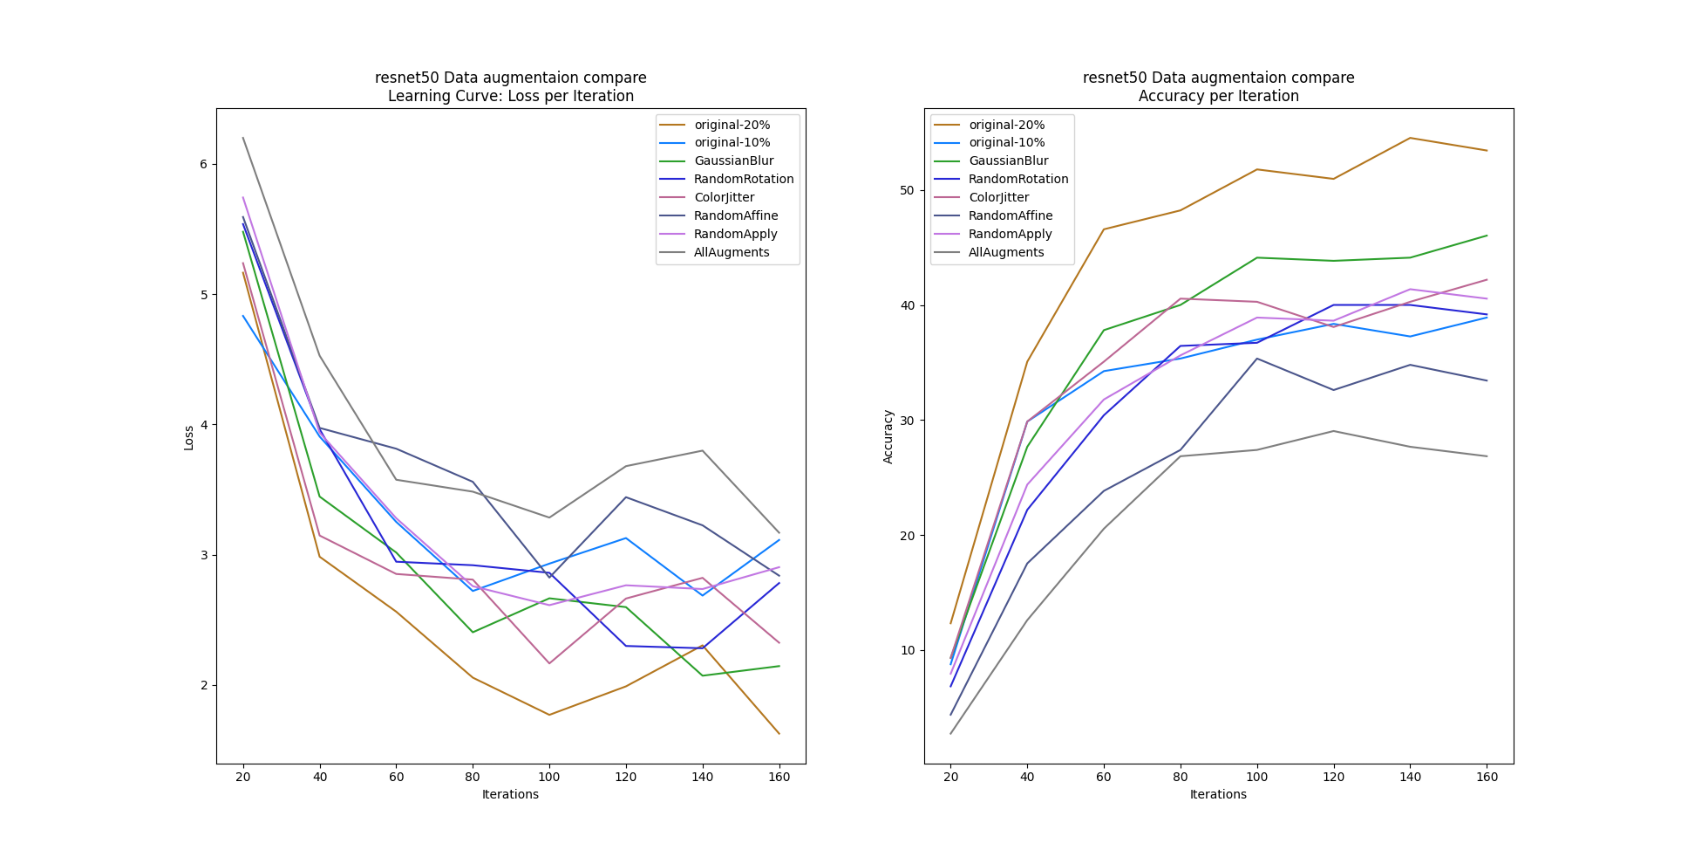

In [ ]:
#Load the results figure from google drive.
print("\n The validation accuracy and loss of each model (ResNet50 trained on each augmented data set):\n")
img = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/DeepProject/plots/Figure_'+str(103)+'.png')
plt.figure(figsize=(30,50))
plt.axis('off')
plt.imshow(img)

The results from the above figure:

* The difference between "original-20%" and "original-10%" is much more significant then "original-50%" and "original-100%".

* Most of the augmented data sets achived better results then "original-10%".

* RandomAffine and AllAguments achive less accuracy then "original-10%".

### Part C - Main Conclusions


From the results above and the previous results, we can conclude:

* The data augmentation technique is effective in specific cases, especially when the amount of data is relativly small. In other cases, when there are enough data sampels, the data augmentation technique does not improve the training results, and sometimes even reduce the training accuracy.

* In case of training with relativly small data set, the best augmentatation technique is "Gaussian Blur" which improve the validation accuracy by 8%, which is half of the difference between the val accuracy with the twice amount of data samples (i.e. "original-20%).

* from the curves of the training results with the "AllAugments" and the "Random Affine" datasets, we conclude that some of the augmentation techniques can actually decrese the val accuracy even though they only add more data samples to the ("original-10%") training set. from this fact we can conclude that some times "less is more", i.e. some of the augmentation techniques only "confuse" the model and damage the training process.